<a href="https://colab.research.google.com/github/oleksnikolenko/BitcoinPriceChecker_rx/blob/master/Quadratic_Equations_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as tfl
import seaborn as sbn
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib import pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Preprocessing

In [ ]:
# Parse data
rows = pd.read_csv('/content/gdrive/MyDrive/train.csv')

data = []
quadratic_labels = []
linear_labels = []
constant_labels = []

for i, row in rows.iterrows():
  (filename, quadratic, linear, constant) = row
  
  imagePath = '/content/gdrive/MyDrive/training_set/' + filename
  image = load_img(imagePath, target_size=(512, 512), color_mode='grayscale')
  image = img_to_array(image)

  data.append(image)
  quadratic_labels.append(quadratic)
  linear_labels.append(linear)
  constant_labels.append(constant)

data = np.array(data, dtype="float32") / 255.0

In [ ]:
# Binarize labels
lb = LabelBinarizer()
quadratic_labels = lb.fit_transform(quadratic_labels)
linear_labels = lb.fit_transform(linear_labels)
constant_labels = lb.fit_transform(constant_labels)

In [ ]:
# Split To Train and Test
split = train_test_split(data, quadratic_labels, linear_labels, constant_labels, test_size=0.30)
train_images, test_images, train_quadratic_y, test_quadratic_y, train_linear_y, test_linear_y, train_constant_y, test_constant_y = split

# Split Test to Validation and Test
val_test_split = train_test_split(test_images, test_quadratic_y, test_linear_y, test_constant_y, test_size=0.5)
val_images, test_images, val_quadratic_y, test_quadratic_y, val_linear_y, test_linear_y, val_constant_y, test_constant_y = val_test_split

print(train_quadratic_y[0])
print(val_quadratic_y[0])
print(test_quadratic_y[0])

[0 0 0 0 0 1 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 0 0]


# Model

In [ ]:
# Build Models
def build_branch(inputs, numClasses, name):
	
		# Conv block 1
		x = tfl.Conv2D(16, (3, 3), padding="same", activation='relu')(inputs)
		x = tfl.BatchNormalization()(x)
		x = tfl.MaxPooling2D(pool_size=(3, 3))(x)
		x = tfl.Dropout(0.25)(x)
	
		# Conv block 2
		x = tfl.Conv2D(32, (3, 3), padding="same", activation='relu')(x)
		x = tfl.BatchNormalization()(x)
		x = tfl.MaxPooling2D(pool_size=(2, 2))(x)
		x = tfl.Dropout(0.25)(x)
	
		# Conv block 3
		x = tfl.Conv2D(32, (3, 3), padding="same", activation='relu')(x)
		x = tfl.BatchNormalization()(x)
		x = tfl.MaxPooling2D(pool_size=(2, 2))(x)
		x = tfl.Dropout(0.25)(x)

		# FC
		x = tfl.Flatten()(x)
		x = tfl.Dense(128,activation='relu')(x)
		x = tfl.BatchNormalization()(x)
		x = tfl.Dropout(0.5)(x)
		x = tfl.Dense(numClasses, activation='softmax', name=name)(x)

		return x

inputs = tfl.Input(shape=(512, 512, 1))
quadr = build_branch(inputs, 10, 'quadratic')
linear = build_branch(inputs, 11, 'linear')
constant = build_branch(inputs, 11, 'constant')

model = Model(inputs = inputs, outputs=[quadr, linear, constant])

In [ ]:
# Compile and train Model
NUM_EPOCHS = 64
LEARNING_RATE = 1e-3
BATCH_SIZE = 32

opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

loss_weights = {"quadratic": 1.0, "linear": 1.0, 'constant': 1.0}

losses = {
	"quadratic": "categorical_crossentropy",
	"linear": "categorical_crossentropy",
  'constant': "categorical_crossentropy"
}

model.compile(loss=losses, optimizer=opt, metrics=['accuracy'], loss_weights=loss_weights)

H = model.fit(x=train_images,
              y={'quadratic': train_quadratic_y, 'linear': train_linear_y, 'constant': train_constant_y},
              validation_data=(val_images, {'quadratic': val_quadratic_y, 'linear': val_linear_y, 'constant': val_constant_y}),
              epochs=NUM_EPOCHS,
              batch_size=BATCH_SIZE)


# Plotting the results

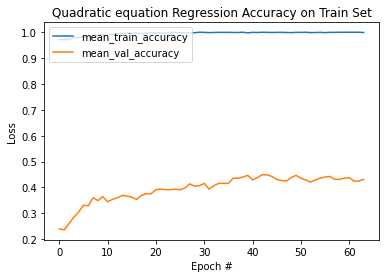

In [ ]:
# Plot accuracy for train/val
mean_train_accuracy = (np.asarray(H.history['quadratic_accuracy']) + \
                       np.asarray(H.history['linear_accuracy']) + \
                       np.asarray(H.history['constant_accuracy'])) / 3
mean_val_accuracy = (np.asarray(H.history['val_quadratic_accuracy']) + \
                     np.asarray(H.history['val_linear_accuracy']) + \
                     np.asarray(H.history['val_constant_accuracy'])) / 3

plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), mean_train_accuracy, label="mean_train_accuracy")
plt.plot(np.arange(0, NUM_EPOCHS), mean_val_accuracy, label="mean_val_accuracy")
plt.title("Quadratic equation Regression Accuracy on Train Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper left")

In [ ]:
# Count number of errors for test set
(quadr, linear, constant) = model.predict(test_images)
(quadr, linear, constant) = lb.inverse_transform(quadr), lb.inverse_transform(linear), lb.inverse_transform(constant)

number_errors = 0

for i in range(len(quadr)):
  if quadr[i] != lb.inverse_transform(test_quadratic_y)[i]:
    number_errors += 1
  if linear[i] != lb.inverse_transform(test_linear_y)[i]:
    number_errors += 1
  if constant[i] != lb.inverse_transform(test_constant_y)[i]:
    number_errors += 1
  
print('\n total number of errors: ', number_errors, ' out of ', (len(quadr) + len(linear) + len(constant)))


 total number of errors:  233  out of  450


# Confusion Matrices

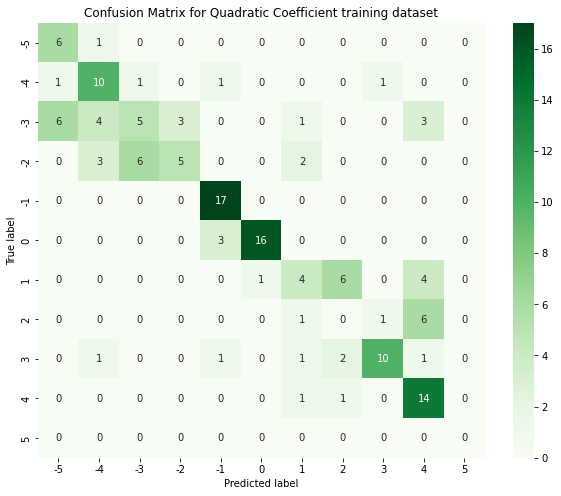

In [ ]:
# Confusion Matrix for Quadratic Coefficients

matrix = confusion_matrix(lb.inverse_transform(test_quadratic_y), lb.inverse_transform(quadr), labels=lb.classes_)
plt.show()

matrix = pd.DataFrame(matrix, index=lb.classes_, columns=lb.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
sbn.heatmap(matrix, annot=True, cmap='Greens')
plt.title('Confusion Matrix for Quadratic Coefficient training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

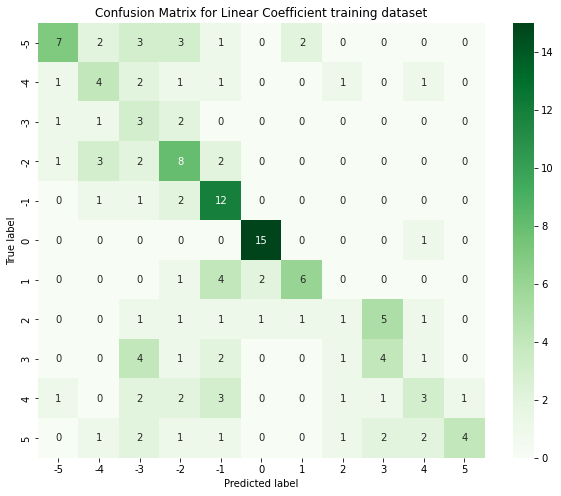

In [ ]:
# Confusion Matrix for Linear Coefficients

matrix = confusion_matrix(lb.inverse_transform(test_linear_y), lb.inverse_transform(linear), labels=lb.classes_)
plt.show()

matrix = pd.DataFrame(matrix, index=lb.classes_, columns=lb.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
sbn.heatmap(matrix, annot=True, cmap='Greens')
plt.title('Confusion Matrix for Linear Coefficient training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

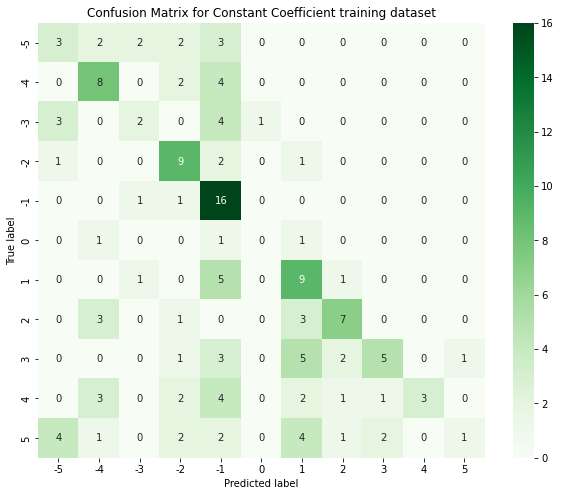

In [ ]:
# Confusion Matrix for Constant Coefficients

matrix = confusion_matrix(lb.inverse_transform(test_constant_y), lb.inverse_transform(constant), labels=lb.classes_)
plt.show()

matrix = pd.DataFrame(matrix, index=lb.classes_, columns=lb.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
sbn.heatmap(matrix, annot=True, cmap='Greens')
plt.title('Confusion Matrix for Constant Coefficient training dataset')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()